In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable


# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
%load_ext autoreload
%autoreload 2

<function matplotlib.pyplot.show(close=None, block=None)>

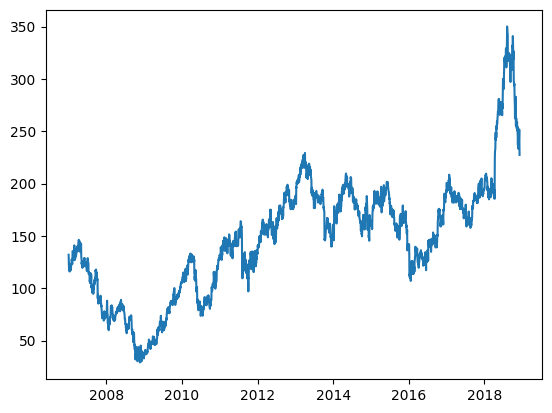

In [3]:
df=pd.read_csv('003.csv',index_col='Date',parse_dates=True)
plt.plot(df.Close)
plt.show

In [4]:
X, y = df.drop(columns=['Close']), df.Close.values
# X.shape, y.shape
X

,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-02,127.000000,133.000000,127.000000,76.526367,420128,0.0,0.0
2007-01-03,131.500000,133.000000,127.250000,73.772598,517141,0.0,0.0
2007-01-04,125.000000,127.000000,121.750000,70.873871,679753,0.0,0.0
2007-01-05,118.000000,121.250000,115.000000,69.859299,1503804,0.0,0.0
2007-01-08,121.500000,124.500000,121.500000,71.743469,547970,0.0,0.0
...,...,...,...,...,...,...,...
2018-11-30,245.600006,245.600006,238.600006,196.626358,510342,0.0,0.0
2018-12-03,245.899994,255.600006,245.800003,206.036270,346959,0.0,0.0
2018-12-04,252.100006,254.899994,248.199997,203.990646,411592,0.0,0.0


PCA to reduce the first four highly coorelated columns to 1 pca_score column

In [5]:
from sklearn.decomposition import PCA
X, y = df.drop(columns=['Close']), df.Close.values
# Create a PCA instance with 1 component
X_pca=X[['Open','High','Low','Adj Close']]

pca = PCA(n_components=1)

# Fit the PCA model to your data and transform the data
pca_result = pca.fit_transform(X_pca)

# Create a new DataFrame with the PCA result
pca_df = pd.DataFrame(data=pca_result, columns=['PCA_Score'])

X['PCA_Score'] = np.array(pca_df['PCA_Score'])

# Drop the original columns
X.drop(['Open','High','Low','Adj Close'], axis=1, inplace=True)

X

,Volume,Dividends,Stock Splits,PCA_Score
Date,,,,
2007-01-02,420128,0.0,0.0,-40.518263
2007-01-03,517141,0.0,0.0,-39.277622
2007-01-04,679753,0.0,0.0,-49.882945
2007-01-05,1503804,0.0,0.0,-60.426381
2007-01-08,547970,0.0,0.0,-52.744499
...,...,...,...,...
2018-11-30,510342,0.0,0.0,190.092241
2018-12-03,346959,0.0,0.0,203.328887
2018-12-04,411592,0.0,0.0,206.501367


Scaling the data as per Requirement

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm=MinMaxScaler()
ss = StandardScaler()
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

X_trans

array([[-0.47444927, -0.05938888,  0.        , -0.36570105],
       [-0.30786179, -0.05938888,  0.        , -0.35450355],
       [-0.02862991, -0.05938888,  0.        , -0.45022279],
       ...,
       [-0.489107  , -0.05938888,  0.        ,  1.86379579],
       [-0.73760847, -0.05938888,  0.        ,  1.69238571],
       [-0.39965121, -0.05938888,  0.        ,  1.53258968]])

In [7]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences):
            break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix,-1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(2852, 100, 4) (2852, 50)


In [8]:
total_samples = len(X)

train_test_cutoff = round(0.96 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff-2)]
X_test = X_ss[-(total_samples-train_test_cutoff-2):]

y_train = y_mm[:-(total_samples-train_test_cutoff-2)]
y_test = y_mm[-(total_samples-train_test_cutoff-2):] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 


Training Shape: (2734, 100, 4) (2734, 50)
Testing Shape: (118, 100, 4) (118, 50)


In [9]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [10]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2734, 100, 4]) torch.Size([2734, 50])
Testing Shape: torch.Size([118, 100, 4]) torch.Size([118, 50])


In [ ]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

In [24]:
y_check[-1]

array([331.70001221, 333.8999939 , 340.8999939 , 338.20001221,
       331.        , 328.6000061 , 318.70001221, 326.5       ,
       308.5       , 298.5       , 296.8999939 , 293.70001221,
       294.79998779, 295.3999939 , 285.6000061 , 283.8999939 ,
       273.20001221, 262.20001221, 269.79998779, 270.5       ,
       265.70001221, 273.3999939 , 266.20001221, 282.8999939 ,
       255.1000061 , 262.8999939 , 261.6000061 , 261.70001221,
       260.3999939 , 258.8999939 , 252.80000305, 258.79998779,
       251.3999939 , 250.80000305, 254.3999939 , 252.        ,
       244.19999695, 237.        , 243.19999695, 239.80000305,
       233.3999939 , 239.80000305, 240.6000061 , 239.30000305,
       241.19999695, 240.30000305, 251.80000305, 249.30000305,
       240.        , 227.3999939 ])

In [13]:
df.Close

Date
2007-01-02    132.000000
2007-01-03    127.250000
2007-01-04    122.250000
2007-01-05    120.500000
2007-01-08    123.750000
                 ...    
2018-11-30    240.300003
2018-12-03    251.800003
2018-12-04    249.300003
2018-12-05    240.000000
2018-12-06    227.399994
Name: Close, Length: 3000, dtype: float64

Writing the LSTM class and functions

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [15]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

In [19]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 500 # 1000 epochs
learning_rate = 0.01 # 0.001 lr
input_size = 4 # number of features
hidden_size = 100 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [20]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [21]:
training_loop(n_epochs=n_epochs,lstm=lstm,optimiser=optimiser,loss_fn=loss_fn,X_train=X_train_tensors_final,y_train=y_train_tensors,X_test=X_test_tensors_final,y_test=y_test_tensors)

Epoch: 0, train loss: 0.14452, test loss: 0.58692
Epoch: 10, train loss: 0.07849, test loss: 0.45629
Epoch: 20, train loss: 0.00691, test loss: 0.10175
Epoch: 30, train loss: 0.00643, test loss: 0.01261
Epoch: 40, train loss: 0.00359, test loss: 0.03784
Epoch: 50, train loss: 0.00261, test loss: 0.03241
Epoch: 60, train loss: 0.00240, test loss: 0.02011
Epoch: 70, train loss: 0.00225, test loss: 0.01800
Epoch: 80, train loss: 0.00221, test loss: 0.01621
Epoch: 90, train loss: 0.00218, test loss: 0.01631
Epoch: 100, train loss: 0.00216, test loss: 0.01644
Epoch: 110, train loss: 0.00215, test loss: 0.01616
Epoch: 120, train loss: 0.00214, test loss: 0.01581
Epoch: 130, train loss: 0.00213, test loss: 0.01560
Epoch: 140, train loss: 0.00212, test loss: 0.01548
Epoch: 150, train loss: 0.00212, test loss: 0.01547
Epoch: 160, train loss: 0.00211, test loss: 0.01544
Epoch: 170, train loss: 0.00210, test loss: 0.01532
Epoch: 180, train loss: 0.00210, test loss: 0.01518
Epoch: 190, train loss:

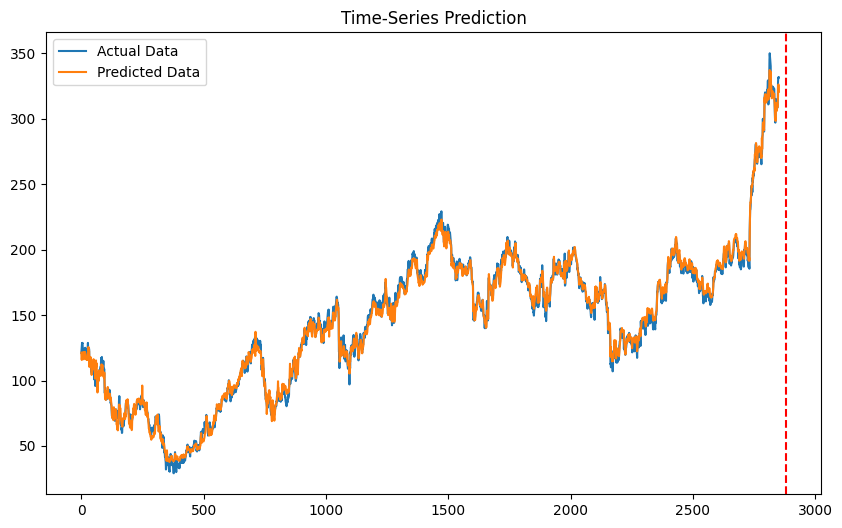

In [22]:
df_X_ss = ss.transform(X) # old transformers
df_y_mm = mm.transform(y.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

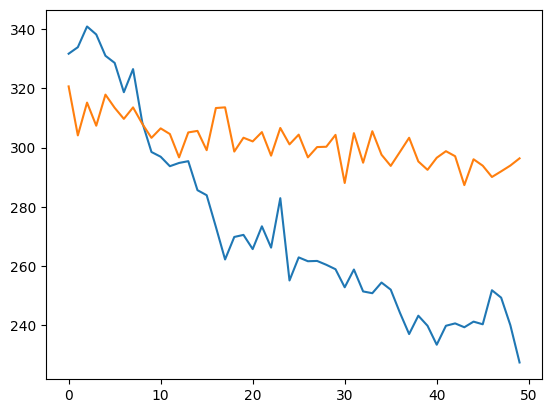

In [23]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show()